## Compute LVMI

- The use of the longer LV length between the apical two- and four-chamber views is recommended.
- LV mass should be measured from the apical four- and two-chamber views and short axis mid view.
- Note: Two-dimensional echocardiographic image acquisition should aim to maximize LV areas, while avoiding foreshortening of the left ventricle

- Measurements and feature names:
    - LVMI - Left ventricle mass index

- LV mass measurements should be reported indexed to BSA. For general reference, 2D echocardiographic 
    - LV mass of 103 g/m2 for men and 89 g/m2 for women should be used as the upper limits of the corresponding normal range.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy
from scipy.stats import mannwhitneyu
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import cohen_kappa_score

from utils import util_measurement, stats_and_plots, measurements_dict, BA_plot

In [2]:
def get_dataCat(df,feature1, value):
    """
    transform feature value in categorical
    Input: 
        - dataframe 
        - feature to be categorized. E.g., LAVI_echo_cat, LAV_echo, LAV_model LVMI_echo_cat, LVEF_echo, etc.
        - value to use as normal - Use 0 for RAVI, and RV, 35 for LVEF, normal for others
    """

    df_BA = df.copy()
    if feature1 == 'LVEF_echo':
        df_BA[feature1][df_BA[feature1] > value] = 'Normal' 
    else:
        df_BA[feature1][df_BA[feature1] == value] = 'Normal' 

    df_BA[feature1][df_BA[feature1] != 'Normal'] = 'Abnormal'
    return df_BA[feature1]

## Load Numbers table

In [3]:
### Load Clinical Echo Measurements
df_numbers = pd.read_csv('test_data/LV_mass/LV_mass.csv')
df_numbers.describe()

,BSA,LVMI_echo
count,10.000000,10.000000
mean,1.842810,77.447292
std,0.370214,25.730750
min,1.240147,33.410095
25%,1.653606,63.250047
50%,1.685652,70.985370
75%,2.149724,103.260875
max,2.412838,106.848164


## Load dataframes

In [4]:
df_a2c_allFrames = pd.read_csv('test_data/LV_mass/A2C_measures_R2.csv')
df_a2c_allFrames.describe()

,RR,bbox-0,bbox-1,bbox-2,bbox-3,area,filled_area,convex_area,centroid-0,centroid-1,...,y_top,L_disk,Rsquared,RMSE,MSE,cycles,freq,amplitude,phase,offset
count,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
mean,38.60000,101.150000,106.050000,180.550000,167.300000,20.393372,20.393372,22.389221,142.000000,135.850000,...,128.850000,0.287357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,15.96839,48.626693,15.006928,33.301612,18.705755,7.671880,7.671880,8.389253,37.526131,15.125005,...,17.315266,0.073597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,15.00000,43.000000,80.000000,142.000000,144.000000,8.966064,8.966064,9.375000,99.000000,118.000000,...,109.000000,0.164744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,24.00000,54.500000,97.750000,148.500000,156.750000,12.590027,12.590027,13.209534,104.750000,127.750000,...,115.750000,0.217236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,38.00000,112.000000,103.000000,177.000000,167.000000,22.451782,22.451782,25.189209,140.000000,132.500000,...,126.000000,0.298882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,54.00000,145.250000,115.000000,205.500000,170.250000,26.863098,26.863098,28.974915,175.750000,140.500000,...,138.250000,0.353325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,64.00000,166.000000,143.000000,234.000000,232.000000,32.208252,32.208252,32.983398,197.000000,189.000000,...,171.000000,0.383834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df_a4c_allFrames = pd.read_csv('test_data/LV_mass/A4C_measures_R2.csv')
df_a4c_allFrames.describe()

,RR,bbox-0,bbox-1,bbox-2,bbox-3,area,filled_area,convex_area,centroid-0,centroid-1,...,y_top,L_disk,Rsquared,RMSE,MSE,cycles,freq,amplitude,phase,offset
count,40.000000,40.000000,40.000000,40.00000,40.000000,40.000000,40.000000,40.000000,40.00000,40.000000,...,40.000000,40.000000,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.0
mean,43.600000,103.825000,89.850000,175.17500,138.325000,15.377655,15.377655,16.290588,140.90000,113.275000,...,110.425000,0.262375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,17.924056,45.476332,30.376737,30.67939,32.624819,7.488917,7.488917,7.889308,33.86913,29.782965,...,31.950994,0.088394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,15.000000,30.000000,37.000000,133.00000,76.000000,0.262451,0.262451,0.347900,84.00000,57.000000,...,43.000000,0.042417,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,37.000000,58.000000,64.750000,143.00000,111.500000,10.433960,10.433960,10.879517,106.75000,90.000000,...,84.000000,0.179566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,38.500000,110.500000,85.000000,181.50000,135.500000,14.514160,14.514160,15.661621,146.00000,110.000000,...,106.000000,0.277187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,51.000000,140.500000,117.000000,197.00000,167.500000,19.836426,19.836426,21.005249,169.00000,138.750000,...,135.000000,0.329350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,86.000000,176.000000,146.000000,224.00000,194.000000,34.014893,34.014893,35.729980,198.00000,168.000000,...,177.000000,0.439681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_sax_allFrames = pd.read_csv('test_data/LV_mass/SAXMID_measures_R2.csv')
df_sax_allFrames.describe()

,RR,bbox-0,bbox-1,bbox-2,bbox-3,area,filled_area,convex_area,centroid-0,centroid-1,...,y_top,L_disk,Rsquared,RMSE,MSE,cycles,freq,amplitude,phase,offset
count,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,...,20.000000,20.000000,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
mean,40.200000,95.30000,95.850000,170.300000,171.600000,27.514954,27.514954,27.936096,131.850000,132.550000,...,113.450000,0.291415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,15.945961,11.90356,14.658481,14.064139,12.704744,12.663563,12.663563,12.812926,8.616233,9.997236,...,11.245935,0.073771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,15.000000,72.00000,58.000000,146.000000,147.000000,4.687500,4.687500,4.821777,117.000000,110.000000,...,88.000000,0.111483,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,30.000000,86.00000,87.750000,160.000000,163.750000,19.833374,19.833374,20.123291,128.750000,130.750000,...,105.750000,0.262039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,37.500000,94.00000,96.500000,167.500000,172.000000,24.145508,24.145508,24.511719,131.000000,131.500000,...,115.500000,0.279511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,51.000000,104.25000,106.000000,178.750000,179.250000,37.789917,37.789917,38.323975,137.000000,140.250000,...,121.250000,0.362707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,72.000000,117.00000,122.000000,202.000000,196.000000,48.449707,48.449707,49.145508,150.000000,148.000000,...,128.000000,0.386117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Take the LV labels
df_a4c = df_a4c_allFrames[df_a4c_allFrames['label'] == 'LV']
df_a2c = df_a2c_allFrames[df_a2c_allFrames['label'] == 'LV']

# Use only the clips with the best R2 fit to sinusoidal model
df_a4c = df_a4c.sort_values(by='Rsquared', ascending=False).drop_duplicates('anonid')
df_a2c = df_a2c.sort_values(by='Rsquared', ascending=False).drop_duplicates('anonid')

# Take the Saxmid clips with the best R2 fit to sinusoidal model
df_sax_A1 = df_sax_allFrames[df_sax_allFrames['label'] == 'outer_circle']
df_sax_A2 = df_sax_allFrames[df_sax_allFrames['label'] == 'inner_circle']
df_sax = pd.merge(df_sax_A1, df_sax_A2, on=['anonid', 'ID_clip', 'frame'], how='inner', suffixes=('_A1', '_A2'))
df_sax = df_sax.sort_values(by='Rsquared_A1', ascending=False).drop_duplicates(subset='anonid')

# Get the frames with the greatest area:
df_sax = df_sax.sort_values(by='area_A1', ascending=False).drop_duplicates(subset='ID_clip')
df_a4c = df_a4c.sort_values(by='area', ascending=False).drop_duplicates(subset='ID_clip')

print('Number of A4C clips:', df_a4c.shape[0])
print('Number of A2C clips:', df_a2c.shape[0])
print('Number of SAX clips:', df_sax.shape[0])

Number of A4C clips: 10
Number of A2C clips: 10
Number of SAX clips: 10


## Merge the data

In [8]:
# Merge A2C, A4C and SAX
df_all = df_a4c.merge(df_a2c, on='anonid', how='inner', suffixes=('_a4c', '_a2c'))
df_all = df_all.merge(df_sax, on='anonid', how='inner', suffixes=(None, '_sax'))

# Merge with clinical data
df_all = df_all.merge(df_numbers,on=['anonid'],how='inner')

print(f'anonid:{len(df_all.anonid.unique())}, merged:{df_all.shape[0]}, merged anonid:{len(df_all.anonid.unique())}')

anonid:10, merged:10, merged anonid:10


## Calculcate the LVMI

In [9]:
df_vol = df_all.copy()
df_vol = util_measurement.get_volumetrics(df_vol, metric='LV_mass')

  0%|          | 0/10 [00:00<?, ?it/s]/home/ec2-user/miniconda3/envs/ssl-seg/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
100%|██████████| 10/10 [00:00<00:00, 2180.22it/s]


## Bin LV Mass in normal and abnormal

In [10]:
df_vol = df_vol[(df_vol['Pt. Sex'] == 'F') | (df_vol['Pt. Sex'] == 'M')]

## Cat values for Model Pred
df_vol['LVMI_model_cat'] = df_vol['LVMI_model'].astype(int)
df_vol['LVMI_model_cat'] = np.where((df_vol['Pt. Sex'] == 'M'), df_vol['LVMI_model_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.lvmi_echo_male_dict)), df_vol['LVMI_model_cat'])
df_vol['LVMI_model_cat'] = np.where((df_vol['Pt. Sex'] == 'F'), df_vol['LVMI_model_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.lvmi_echo_female_dict)), df_vol['LVMI_model_cat'])

## Cat values for Numbers table 
df_vol['LVMI_echo_cat'] = df_vol['LVMI_echo'].astype(int)
df_vol['LVMI_echo_cat'] = np.where((df_vol['Pt. Sex'] == 'M'), df_vol['LVMI_echo_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.lvmi_echo_male_dict)), df_vol['LVMI_echo_cat'])
df_vol['LVMI_echo_cat'] = np.where((df_vol['Pt. Sex'] == 'F'), df_vol['LVMI_echo_cat'].apply(lambda x: measurements_dict.get_severity(x, measurements_dict.lvmi_echo_female_dict)), df_vol['LVMI_echo_cat'])

## Compute and plot some metrics

Mass - Left Ventricle 
(10, 153)


,LVMI_echo,LVMI_model
mean,77.447292,82.509818
std,25.730750,19.355389
min,33.410095,44.647196
max,106.848164,104.638014


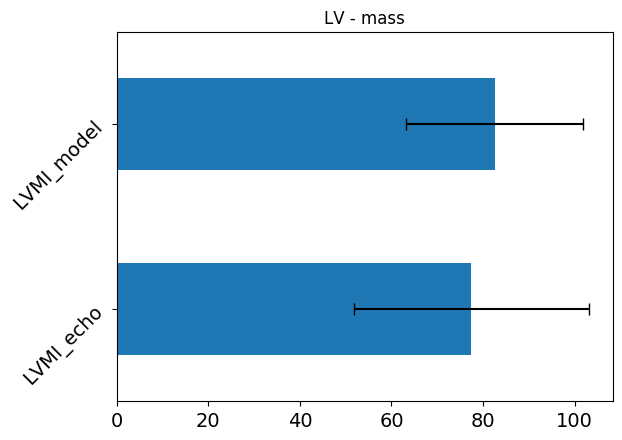

In [11]:
## Mean, std and range of volume.
print('Mass - Left Ventricle ')
print(df_vol.shape)
df_vol_stats  = df_vol[['LVMI_echo', 'LVMI_model']].agg(['mean','std','min', 'max'])
display(df_vol_stats)


df_vol_stats.T.plot(kind = "barh", y = ["mean"], legend = False,
            title = 'LV - mass',fontsize=14,  xerr='std', capsize=4,rot=45)
plt.show()

## Regression and Bland-Altman Plots


10


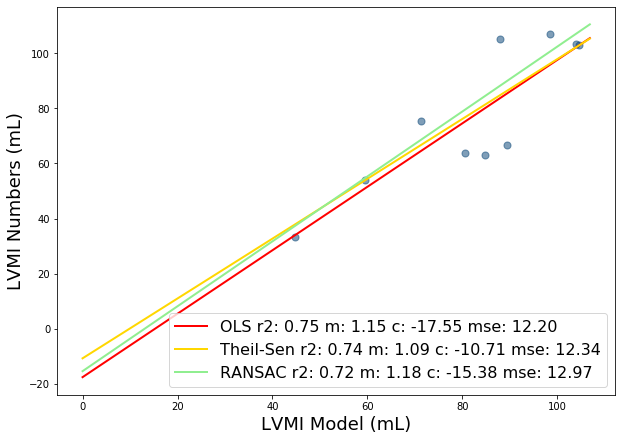

['Normal', 'Abnormal']
['Normal' 'Abnormal']


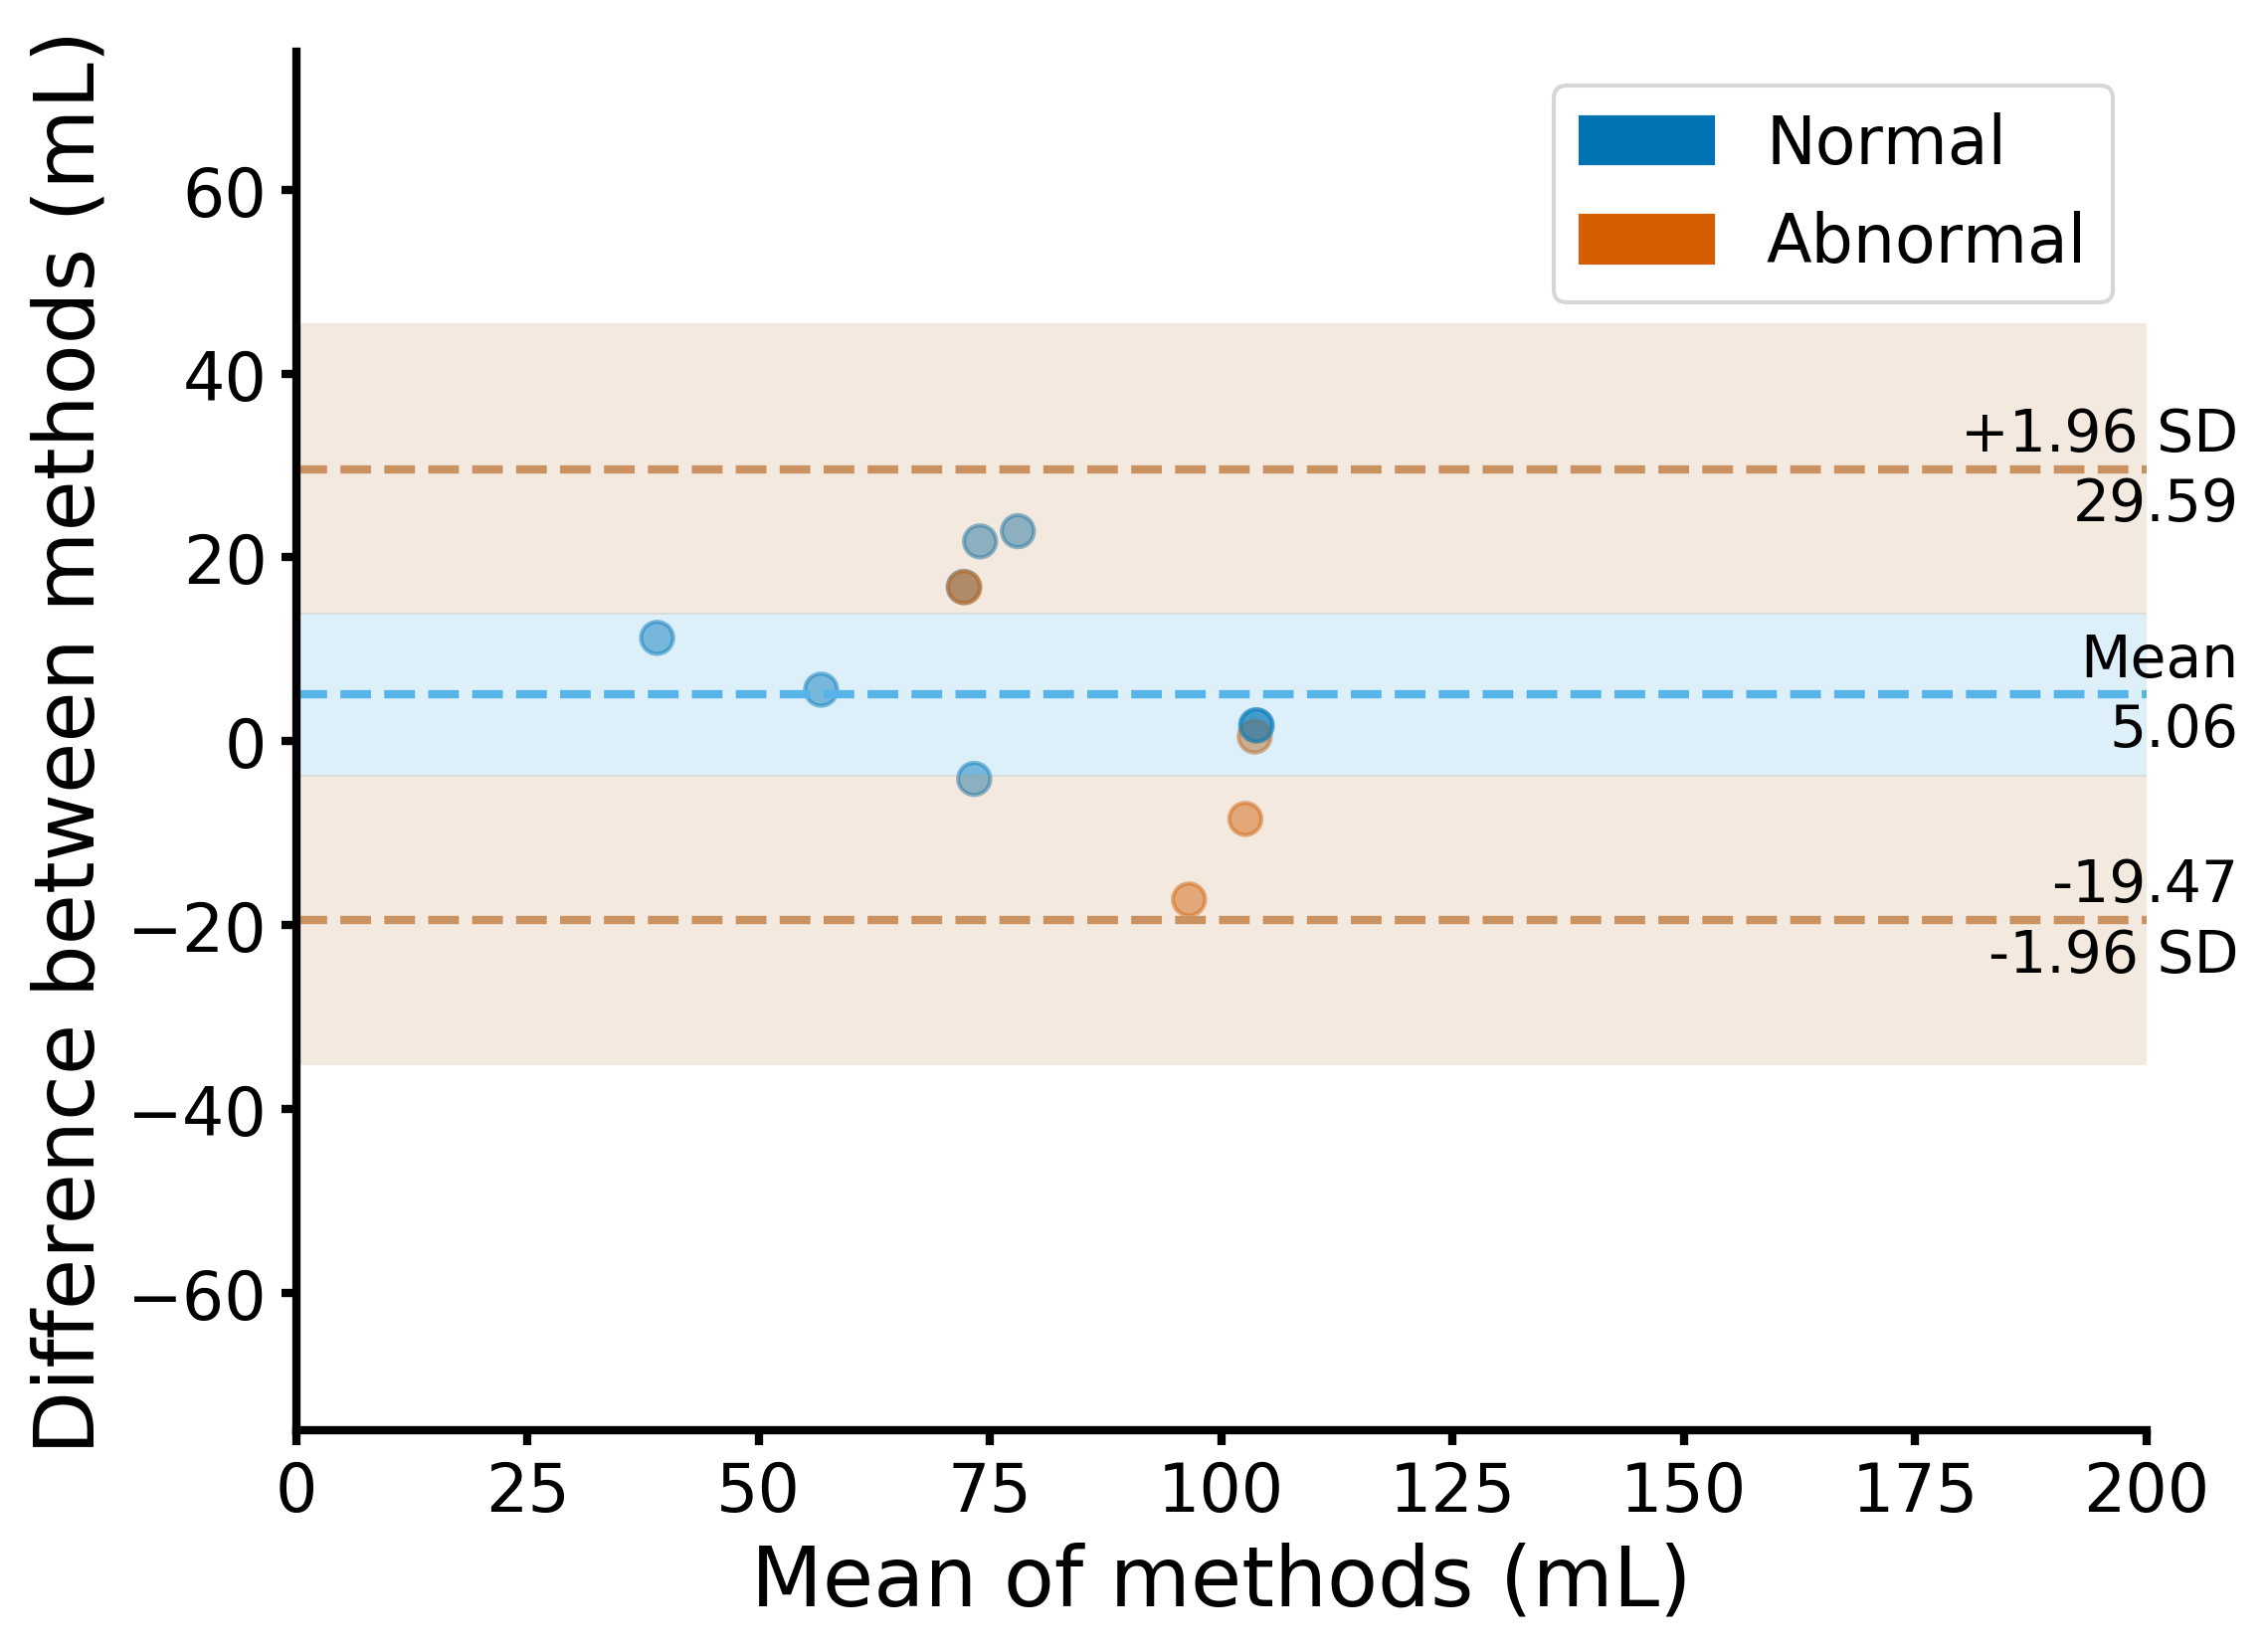

SpearmanrResult(correlation=0.7575757575757575, pvalue=0.011143446799694208)
MWU p-value: MannwhitneyuResult(statistic=46.0, pvalue=0.3956683900503302)


/home/ec2-user/miniconda3/envs/ssl-seg/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [12]:
############ LVMI ##################

df_plot = df_vol

ys = df_plot['LVMI_echo']
xs = df_plot['LVMI_model']
print(len(xs))
stats_and_plots.get_reg_plot(xs, ys,'Numbers-Model', 'LVMI Model', 'LVMI Numbers', 'mL')

dataCat = df_plot.LVMI_echo_cat
BA_plot.blandAltman(xs, ys,dataCat,percentage=False, figureSize=((8,6)),meanColour='#56b4e9', dpi = 300,
                    loaColour='#ca9161', pointColour='#0173b2',lim_inf=-75, lim_sup=75, lim_inf_x=0,
                    lim_sup_x=200, cat=True, unity='mL')

plt.show()
print(scipy.stats.spearmanr(xs,ys))
scipy.stats.normaltest(xs-ys) # (if P < 0.05 then reject normality).
print('MWU p-value:',mannwhitneyu(xs,ys))

## Plot Confusion Matrix

Confusion Matrix - Numbers vs Unet


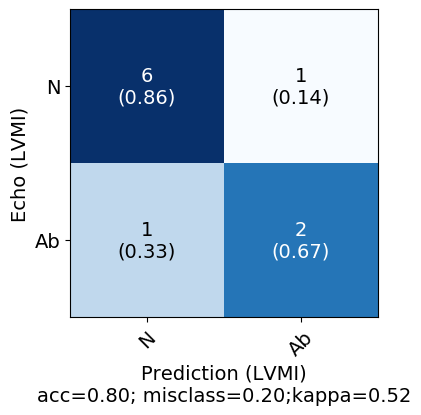

In [13]:
############### LVMI ##################

plt.rcParams.update({'font.size': 14})


y_true = df_vol['LVMI_echo_cat'] == 'Abnormal'
y_pred = df_vol['LVMI_model_cat'] == 'Abnormal'

cm = confusion_matrix(y_true, y_pred) #.ravel()

accuracy = np.trace(cm) / np.sum(cm).astype('float')   ## total samples that were correctly classified
misclass = 1 - accuracy
k = cohen_kappa_score(y_true.astype(int), y_pred.astype(int))

plot_confusion_matrix(conf_mat=cm,colorbar=False,
                                show_absolute=True,
                                show_normed=True,
                                class_names=['N','Ab'],
                                figsize=(4, 4))
plt.ylabel('Echo (LVMI)')
plt.xlabel('Prediction (LVMI)\nacc={:0.2f}; misclass={:0.2f};kappa={:0.2f}'.format(accuracy, misclass,k))
print('Confusion Matrix - Numbers vs Unet')
plt.show()